In [2]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jacfwd
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt

In [3]:
def correct_Cl(Cl, asp0, asp):
    return Cl * (1 + 2/asp0) / (1 + 2/asp)

def read_foil(dat_filepath):
    ''' Reads a .dat file and returns the alpha, CL, and CD data '''
    with open(dat_filepath, 'r') as f: data = np.array([line.split() for line in f.readlines()[7:]], dtype=float)

    alphas = np.deg2rad(data[:,0])
    Cls = data[:,1]
    Cds = data[:,2]

    return alphas, Cls, Cds

In [4]:
def sigmoid(x, s=1):
    return 1 / (1 + np.exp(-s*x))

def poly(coefs, x):
    return jnp.sum(jnp.array([coefs[i] * x**i for i in range(len(coefs))]))

def spline1(x1, y1, dy1):
    a,b = np.linalg.inv([[1, x1],
                         [0, 1]]) @ [y1, dy1]
    return lambda x: a + b*x

def spline2(x1, y1, dy1, x2, y2):
    a,b,c = np.linalg.inv([[1, x1, x1**2],
                            [0, 1, 2*x1],
                            [1, x2, x2**2]]) @ [y1, dy1, y2]
    return lambda x: a + b*x + c*x**2

def spline3(x1, y1, dy1, x2, y2, dy2):
    a,b,c,d = np.linalg.inv([[1, x1, x1**2, x1**3],
                             [0, 1, 2*x1, 3*x1**2],
                             [1, x2, x2**2, x2**3],
                             [0, 1, 2*x2, 3*x2**2]]) @ [y1, dy1, y2, dy2]
    return lambda x: a + b*x + c*x**2 + d*x**3

In [6]:
def plot_foil(alphas, Cls, Cds, Cl_fit_coefs=None, Cd_fit_coefs=None, title='', domain=(-np.pi/6, np.pi/6)):
    ''' Plots the Cl and Cd data against alpha '''
    xs = np.linspace(*domain, 1000)
    alpha_max = 0.95*np.max(alphas)
    Cds_max = poly(Cd_fit_coefs, alpha_max)
    s = 100

    fig, axs = plt.subplots(2, 1, sharex=True)
    fig.suptitle(title)

    axs[0].scatter(alphas, Cls, color='r', s=5, label='data')
    axs[0].set_ylabel('Cl')
    axs[0].set_xlim(domain)
    if Cl_fit_coefs is not None:
        
        left_spline = spline3(-np.pi, 0, 0, -alpha_max, poly(Cl_fit_coefs, -alpha_max), grad(poly, 1)(Cl_fit_coefs, -alpha_max))
        poly_fit = lambda x: poly(Cl_fit_coefs, x)
        right_spline = spline3(np.pi, 0, 0, alpha_max, poly(Cl_fit_coefs, alpha_max), grad(poly, 1)(Cl_fit_coefs, alpha_max))

        fit_Cls = [left_spline(x) * sigmoid(-x-alpha_max, s=s)  + poly_fit(x) * sigmoid(x+alpha_max, s=s) * sigmoid(-x+alpha_max, s=s) + right_spline(x) * sigmoid(x-alpha_max, s=s) for x in xs]
        axs[0].plot(xs, fit_Cls, label='fit')
        axs[0].legend()

    axs[1].scatter(alphas, Cds, color='r', s=5, label='data')
    axs[1].set_ylabel('Cd')
    axs[1].set_xlabel('alpha')
    if Cd_fit_coefs is not None:
        left_spline = spline1(-alpha_max, poly(Cd_fit_coefs, -alpha_max), grad(poly, 1)(Cd_fit_coefs, -alpha_max))
        poly_fit = lambda x: poly(Cd_fit_coefs, x)
        right_spline = spline1(alpha_max, poly(Cd_fit_coefs, alpha_max), grad(poly, 1)(Cd_fit_coefs, alpha_max))

        fit_Cds = [left_spline(x) * sigmoid(-x-alpha_max, s=s) + poly_fit(x) * sigmoid(x+alpha_max, s=s) * sigmoid(-x+alpha_max, s=s) + right_spline(x) * sigmoid(x-alpha_max, s=s) for x in xs]
        axs[1].plot(xs, fit_Cds, label='fit')
        axs[1].legend()

rudder CL fit: (-0.0015163102578792487, 12.500241489875183, 0.07600098028364335, -46.88890123043665)
rudder CD fit: (0.008931808009881621, 0.00177977858338427, -0.13571730556858114, -0.03619944695490296, 7.0314926384606355)
keel CL fit: (0.006258412840982664, 10.599409535901916, -0.40697679817670845, -67.4040719552562)
keel CD fit: (0.010047465912866474, -0.015923841570486316, -0.554973531339051, 0.4800172359540724, 20.40078126797048)
keel alpha_max: 0.28361600344907856


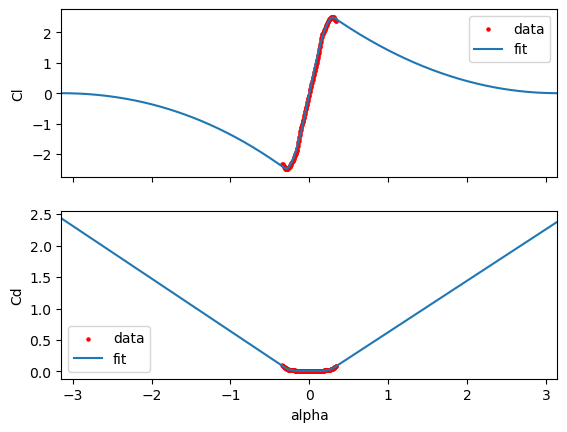

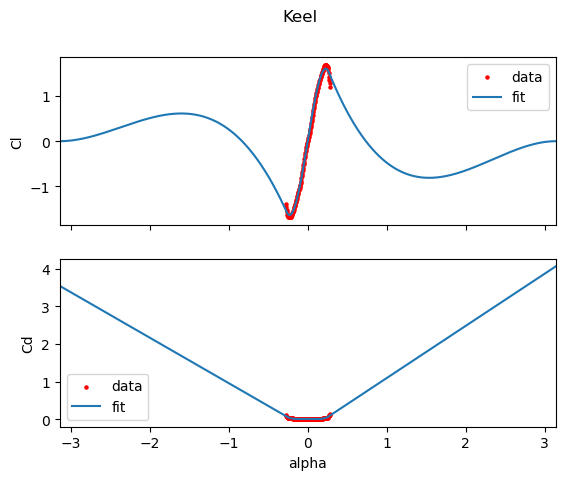

In [9]:
rudder_filepath = '../data/foils/naca0015.dat'
rudder_alphas, rudder_Cls, rudder_Cds = read_foil(rudder_filepath)
rudder_Cls = correct_Cl(rudder_Cls, 1, 2.97)
rudder_Cl_fit_coefs = Polynomial.fit(rudder_alphas, rudder_Cls, 3, domain=(-np.pi,np.pi)).convert().coef
rudder_Cd_fit_coefs = Polynomial.fit(rudder_alphas, rudder_Cds, 4, domain=(-np.pi,np.pi)).convert().coef
plot_foil(rudder_alphas, rudder_Cls, rudder_Cds, rudder_Cl_fit_coefs, rudder_Cd_fit_coefs, domain=(-np.pi, np.pi))
plt.savefig('naca0015.png')

keel_filepath = '../data/foils/naca009.dat'
keel_alphas, keel_Cls, keel_Cds = read_foil(keel_filepath)
keel_Cls = correct_Cl(keel_Cls, 1, 1.75)
keel_Cl_fit_coefs = Polynomial.fit(keel_alphas, keel_Cls, 3, domain=(-np.pi,np.pi)).convert().coef
keel_Cd_fit_coefs = Polynomial.fit(keel_alphas, keel_Cds, 4, domain=(-np.pi,np.pi)).convert().coef
plot_foil(keel_alphas, keel_Cls, keel_Cds, keel_Cl_fit_coefs, keel_Cd_fit_coefs, 'Keel', domain=(-np.pi, np.pi))
plt.savefig('naca009.png')

print(f'rudder CL fit: {tuple(rudder_Cl_fit_coefs)}')
print(f'rudder CD fit: {tuple(rudder_Cd_fit_coefs)}')
print(f'keel CL fit: {tuple(keel_Cl_fit_coefs)}')
print(f'keel CD fit: {tuple(keel_Cd_fit_coefs)}')
print(f'keel alpha_max: {np.max(keel_alphas)}')